# **Tarefa 3: MO433 - Aprendizado não supervisionado**

## **Equipe:**

* Elian Laura  | 265685
* Iury Cleveston  | 230216

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Read the dataset
X = pd.read_csv("dados3.csv")
X_np = np.asarray(X)

## Anomalias por Distância

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA object
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X))

### Distância Euclidiana

In [83]:
# Compute the euclidean distance using the first 5 PC
euclidean = np.zeros(X.shape[0])
for i in range(5):
    euclidean += (T[:,i] - np.mean(T[:,:5]))**2/np.var(T[:,:5])

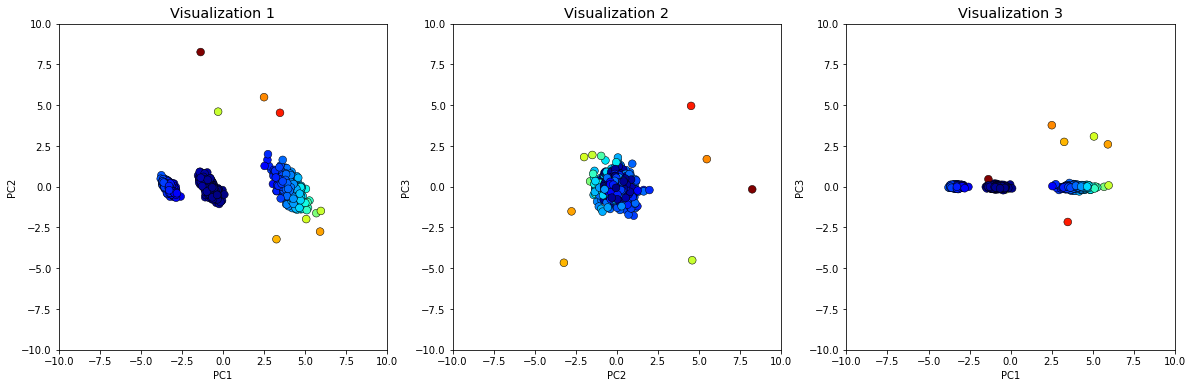

In [84]:
colors = [plt.cm.jet(float(i)/max(euclidean)) for i in euclidean]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
with plt.style.context(('ggplot')):
    ax1.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_xlim((-10, 10))
    ax1.set_ylim((-10, 10))
    ax1.set_title('Visualization 1')
    
    ax2.scatter(T[:, 1], T[:, 2], c=colors, edgecolors='k', s=60)
    ax2.set_xlabel('PC2')
    ax2.set_ylabel('PC3')
    ax2.set_xlim((-10, 10))
    ax2.set_ylim((-10, 10))
    ax2.set_title('Visualization 2')
    
    ax3.scatter(T[:, 0], T[:, 3], c=colors, edgecolors='k', s=60)
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC3')
    ax3.set_xlim((-10, 10))
    ax3.set_ylim((-10, 10))
    ax3.set_title('Visualization 3')
    
plt.show()


### Distância de Mahalanobis

In [85]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

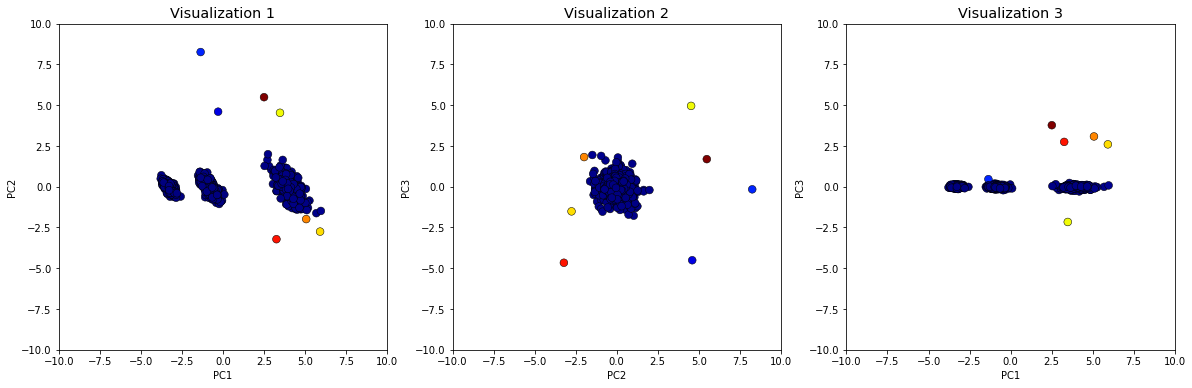

In [86]:
colors = [plt.cm.jet(float(i)/max(m)) for i in m]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
with plt.style.context(('ggplot')):
    ax1.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_xlim((-10, 10))
    ax1.set_ylim((-10, 10))
    ax1.set_title('Visualization 1')
    
    ax2.scatter(T[:, 1], T[:, 2], c=colors, edgecolors='k', s=60)
    ax2.set_xlabel('PC2')
    ax2.set_ylabel('PC3')
    ax2.set_xlim((-10, 10))
    ax2.set_ylim((-10, 10))
    ax2.set_title('Visualization 2')
    
    ax3.scatter(T[:, 0], T[:, 3], c=colors, edgecolors='k', s=60)
    ax3.set_xlabel('PC1')
    ax3.set_ylabel('PC3')
    ax3.set_xlim((-10, 10))
    ax3.set_ylim((-10, 10))
    ax3.set_title('Visualization 3')
    
plt.show()

A partir das distâncias euclidianas e de Mahalanobis dos pontos até os clusteres, é possivel notar que 7 pontos podem ser definidos como anomalias. Chegamos nessa conclusão através do plot para as três principais componentes dos dados originais extraídos via PCA, bem como definimos as cores dos pontos que mais se afastam do centro do cluster. A distância de Mahalanobis proporciona uma separação mais clara dos pontos anômalos.

## Anomalias por Elliptic Envelope, SVM, Isolation Forest, and Local Outlier Factor

In [87]:
import time
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
# from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

In [142]:
def plot(X, y_pred, name):
    
        colors = np.array(["#377eb8", "#ff7f00"])
        
        inl = (y_pred == 1).sum()
        out = (y_pred == -1).sum()

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
        fig.suptitle(name + f" (Outliers: {out})", size=18)
        
        with plt.style.context(('ggplot')):
            ax1.scatter(X[:, 0], X[:, 1], color=colors[(y_pred + 1) // 2], edgecolors='k', s=60)
            ax1.set_xlabel('D1')
            ax1.set_ylabel('D2')
            ax1.set_xlim((-7, 7))
            ax1.set_ylim((-4, 2))
            ax1.set_title('Visualization 1')

            ax2.scatter(X[:, 1], X[:, 2], color=colors[(y_pred + 1) // 2], edgecolors='k', s=60)
            ax2.set_xlabel('D2')
            ax2.set_ylabel('D3')
            ax2.set_xlim((-3, 2))
            ax2.set_ylim((-7, 4))
            ax2.set_title('Visualization 2')

            ax3.scatter(X[:, 0], X[:, 3], color=colors[(y_pred + 1) // 2], edgecolors='k', s=60)
            ax3.set_xlabel('D1')
            ax3.set_ylabel('D3')
            ax3.set_xlim((-7, 7))
            ax3.set_ylim((-4, 4))
            ax3.set_title('Visualization 3')

        plt.show()

def run_algorithms(X, n_samples, outliers_fraction):
    anomaly_algorithms = [
        ("Elliptic Envelope", EllipticEnvelope(contamination = outliers_fraction)),
        ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf")),
#         (
#             "One-Class SVM (SGD)",
#             make_pipeline(
#                 Nystroem(gamma=0.1, random_state=42, n_components=10),
#                 SGDOneClassSVM(
#                     nu=outliers_fraction,
#                     shuffle=True,
#                     fit_intercept=True,
#                     random_state=42,
#                     tol=1e-6,
#                 ),
#             ),
#         ),
        (
            "Isolation Forest",
            IsolationForest(contamination=outliers_fraction, random_state=42),
        ),
        (
            "Local Outlier Factor",
            LocalOutlierFactor(n_neighbors=10, contamination=outliers_fraction),
        ),
    ]
    

    for name, algorithm in anomaly_algorithms:        
  

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        plot(X, y_pred, name)

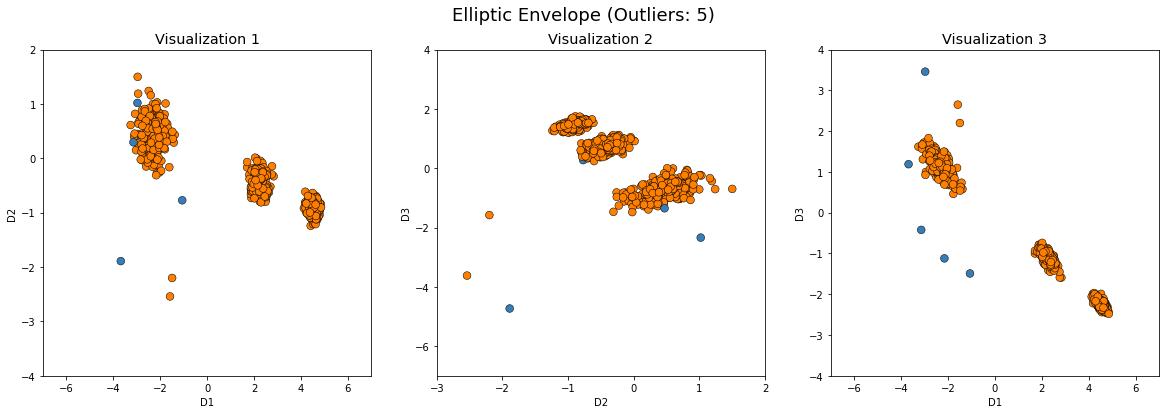

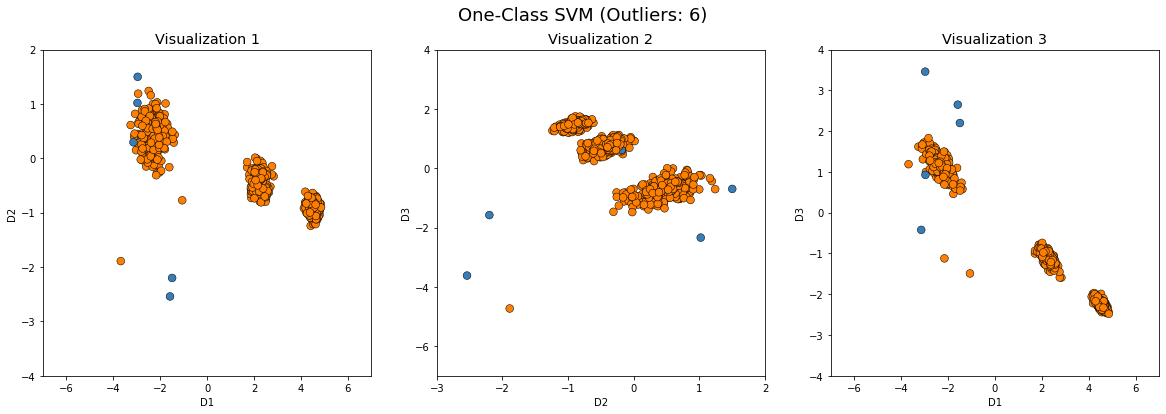

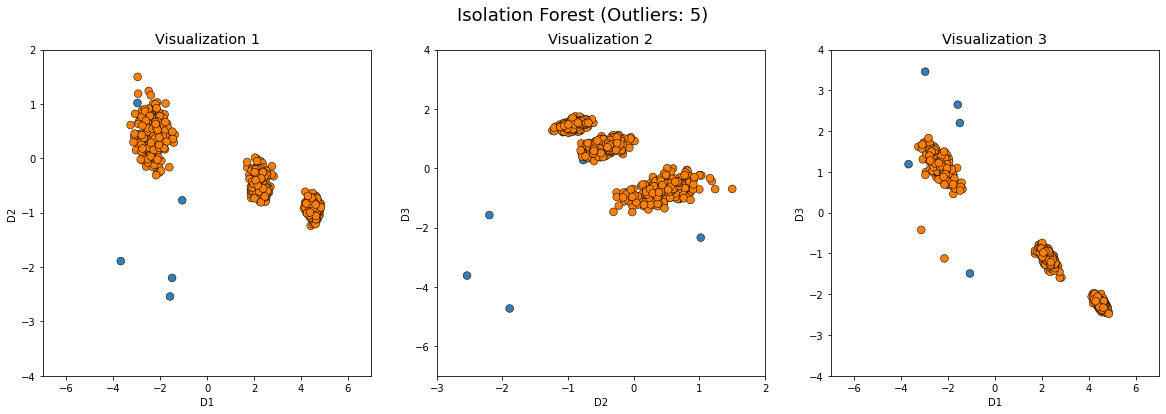

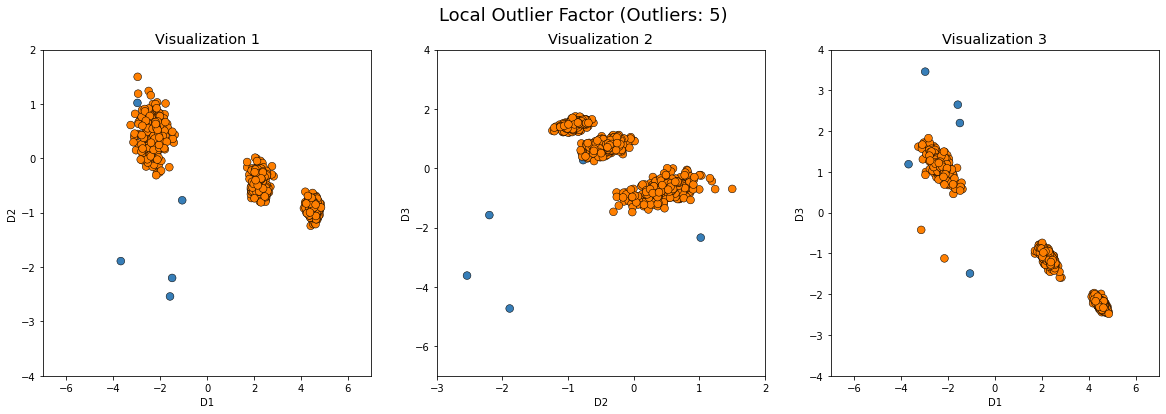

In [143]:

n_samples = X_np.shape[0]
outliers_fraction = 0.005


# Call algorithms
run_algorithms(X_np, n_samples, outliers_fraction)

Utilizando algoritmos para determinar anomalias como Elliptic Envelope, SVM, Isolation Forest, and Local Outlier Factor, obtemos um corportamento similar ao da inspeção visual. Contudo o valor para contaminação teve de ser definido como 0.005, caso contrário o número de outliers encontrados é muito elevado. Os algoritmos encontraram 5 outliers, com exceção da One Class SVM, que encontrou 6. De forma similar, foi plotado três dimensões dos dados originais, juntamente com a sinalização de quais pontos são outliers (na cor azul). Observa-se divergência entre os algoritmos sobre quais pontos são determinados como outliers.